In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import lightgbm as lgbm
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, f1_score, RocCurveDisplay, roc_auc_score
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['matchName', 'demoId', 'roundNum'])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,matchName,demoId,roundNum
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 102 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(2), uint8(10)
memory usage: 5.1+ GB


In [6]:
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["matchName", "winningSideCT"])

## All dataset

In [7]:
filtr = ~df.matchName.str.endswith("iem-katowice-2022")
df = df[filtr].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7137130 entries, 0 to 7137129
Columns: 102 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(2), uint8(10)
memory usage: 4.8+ GB


In [8]:
y = y[filtr].drop(['matchName'], axis='columns')
y = y.reset_index(drop=True)
y

,winningSideCT
0,0
1,0
2,0
3,0
4,0
...,...
7137125,1
7137126,1
7137127,1
7137128,1


In [9]:
groupped = df.groupby(['demoId'])
samples_indexes = groupped.indices
len(samples_indexes)

1494

In [10]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((5709205,), (1427925,))

In [11]:
X = df.drop(['demoId', 'roundNum', 'matchName'], axis='columns')
y = y.squeeze()
X.shape, y.shape

((7137130, 99), (7137130,))

In [12]:
X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape

((5709205, 99), (1427925, 99))

In [13]:
X_test = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat())
y_test = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
y_test = y_test.squeeze()
X_test.shape

(620392, 99)

In [14]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.518687
 0    0.481313
 Name: winningSideCT, dtype: float64,
 1    0.522383
 0    0.477617
 Name: winningSideCT, dtype: float64,
 1    0.5046
 0    0.4954
 Name: winningSideCT, dtype: float64)

In [15]:
parameters = {
    "num_leaves": Integer(4, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
    "subsample_freq": Integer(0, 2)
}

opt = BayesSearchCV(lgbm.LGBMClassifier(n_jobs=6),
                    search_spaces=parameters,
                    scoring="neg_log_loss",
                    n_iter=50,
                    n_jobs=3,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=3),
                    verbose=1,
                    random_state=42,
                    refit=True)
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=LGBMClassifier(n_jobs=6),
              fit_params={'eval_set': [(            seconds  ctAlivePlayers  ctEqVal  tAlivePlayers  tEqVal  ct_armor  \
5636       0.472441               5     4400              5    3700       400   
5637       0.976378               5     4400              5    3700       400   
5638       1.480315               5     4400              5    4400       400   
5639       1.984252               5     4400              5    4400       400   
5640       2.488189               5     4400              5    4400       400   
...             ...             ...      ...            ...     ...       ...   
7127201   99.5...
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=4, high=70, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize'),
                             'subsample_freq': Integer(low=0, high=2, prior='uniform', transform='normalize')},
              verbose=1)

In [16]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_num_leaves,param_subsample,param_subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,280.221406,0.756044,42.227581,0.420606,34,973,66,0.72632,1,"{'max_depth': 34, 'n_estimators': 973, 'num_le...",-0.477879,-0.478729,-0.476576,-0.477728,0.000885,50
11,528.410985,12.490960,44.295923,3.590677,61,1300,49,0.608141,2,"{'max_depth': 61, 'n_estimators': 1300, 'num_l...",-0.478491,-0.478060,-0.476177,-0.477576,0.001005,49
8,257.578822,0.820965,40.174902,0.429895,77,941,62,0.766328,1,"{'max_depth': 77, 'n_estimators': 941, 'num_le...",-0.475964,-0.475408,-0.473778,-0.475050,0.000928,48
17,288.144143,0.436206,42.858203,0.228759,75,1074,45,0.924832,1,"{'max_depth': 75, 'n_estimators': 1074, 'num_l...",-0.474804,-0.471090,-0.468996,-0.471630,0.002402,47
7,316.392583,0.600810,47.382356,0.481269,44,1204,37,0.935063,1,"{'max_depth': 44, 'n_estimators': 1204, 'num_l...",-0.471900,-0.469636,-0.468916,-0.470151,0.001272,46
6,270.243594,0.777282,35.843417,0.177439,50,1030,28,0.94973,1,"{'max_depth': 50, 'n_estimators': 1030, 'num_l...",-0.461602,-0.460769,-0.461145,-0.461172,0.000341,45
1,575.221489,0.124047,39.950764,0.412445,67,1160,24,0.98049,2,"{'max_depth': 67, 'n_estimators': 1160, 'num_l...",-0.461288,-0.459802,-0.459960,-0.460350,0.000666,44
4,326.844562,8.045508,16.200199,3.708085,64,626,39,0.886285,2,"{'max_depth': 64, 'n_estimators': 626, 'num_le...",-0.458630,-0.458403,-0.457111,-0.458048,0.000669,43
10,140.394117,0.244694,17.586868,0.323600,19,443,51,0.826899,1,"{'max_depth': 19, 'n_estimators': 443, 'num_le...",-0.457477,-0.455233,-0.455161,-0.455957,0.001075,42
5,492.339318,8.335745,32.582800,2.399765,59,1227,15,0.67537,2,"{'max_depth': 59, 'n_estimators': 1227, 'num_l...",-0.457153,-0.454549,-0.454658,-0.455453,0.001203,41


In [17]:
model_lgbm = opt.best_estimator_
explainer = shap.TreeExplainer(model_lgbm)
shap_values = explainer(X_test)

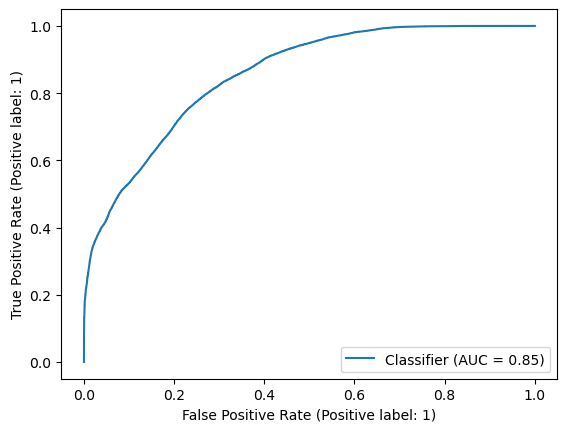

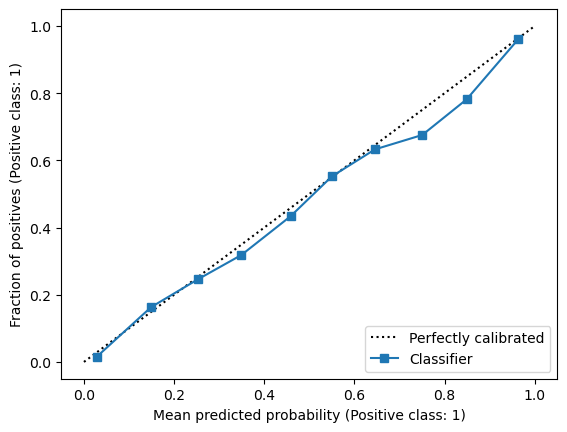

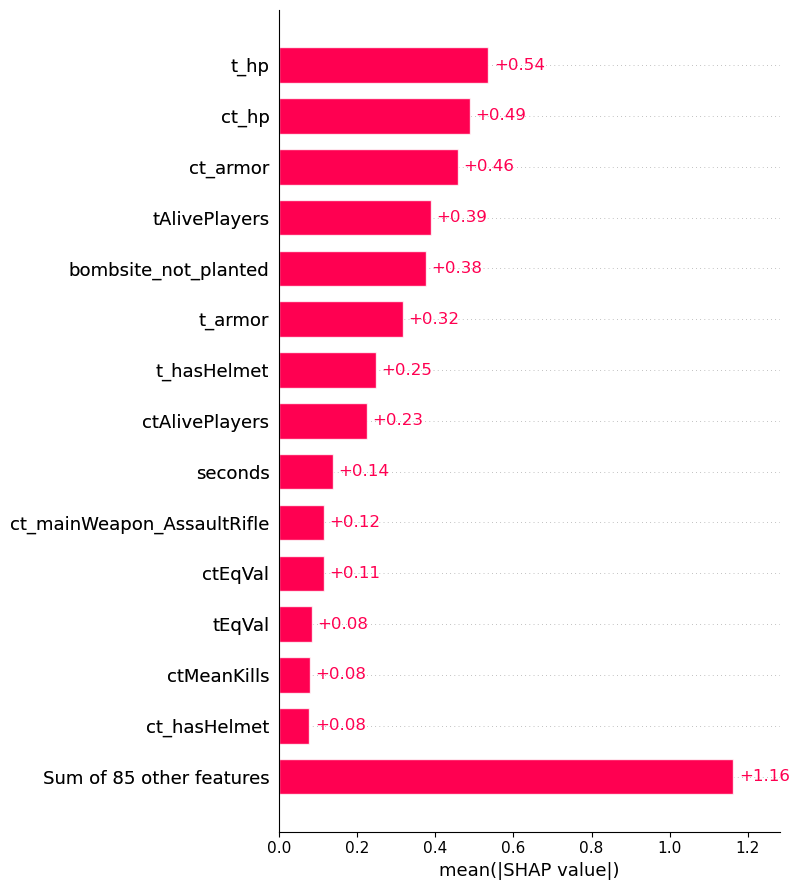

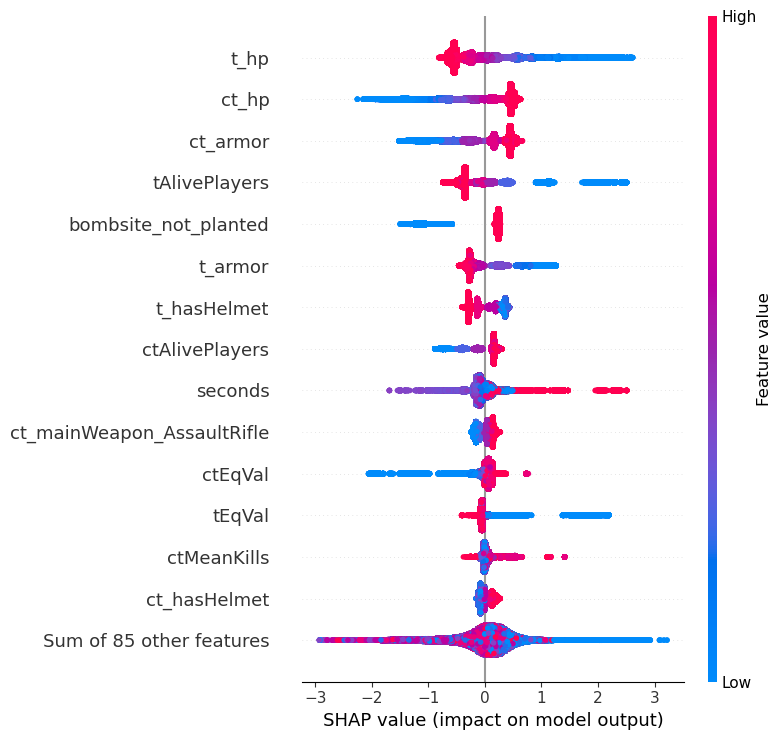

In [18]:
run_name = "LGBM - ESTA All Dataset My Test"
additional_description = "LGBM ESTA All Dataset My Test"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_lgbm.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_lgbm.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = model_lgbm.feature_name_
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_lgbm, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values[:, :, 1], show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [19]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [20]:
results = []
y_true = test_y
y_pred = model_lgbm.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.45876345451293243,
 'LogLoss (future)': 0.4580297767139694,
 'LogLoss (past)': 0.4594475639656108,
 'AUC-ROC (all)': 0.8544314253258727,
 'AUC-ROC (future)': 0.8562648042060578,
 'AUC-ROC (past)': 0.8522449967469238}